# Lesson 1 (and perhaps 2) with my dataset

Ok, so this will be my attempt at doing everything I learnt in Lesson 1 and perhaps Lesson 2.
Note to self: type everything out, no copy paste.

### Prediction problem I'm trying to solve: Given a facial photo, can AI tell me how I'm feeling in that.

First include essential instructions and libraries.

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai import *
from fastai.vision import *

### Question: 
Why import vision separately, doesn't the line before it import all fastai libraries anyway?

Setting batch size to 64 for now. If you run out of memory, set to 16

In [9]:
bs=64

# KDEF Dataset - Running e2e on this first.

## Download / Prepare dataset

In [11]:
folderfilearray = [('happy', 'urls_happy.txt'),('sad', 'urls_sad.txt'),('angry', 'urls_angry.txt')]
path = Path('data/kdef')
classes = []
for i in range(len(folderfilearray)):
    classes.append(folderfilearray[i][0])
print(classes)

['happy', 'sad', 'angry']


Images are already downloaded into specific folders. Only need to verify them.

In [12]:
for i in range(len(folderfilearray)):
    dest = path/classes[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to data/kdef/happy

Verifying images now..


Destination folder set to data/kdef/sad

Verifying images now..


Destination folder set to data/kdef/angry

Verifying images now..


Creating image databunch on this dataset now...

In [13]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['angry', 'happy', 'sad'], 3, 1652, 447)

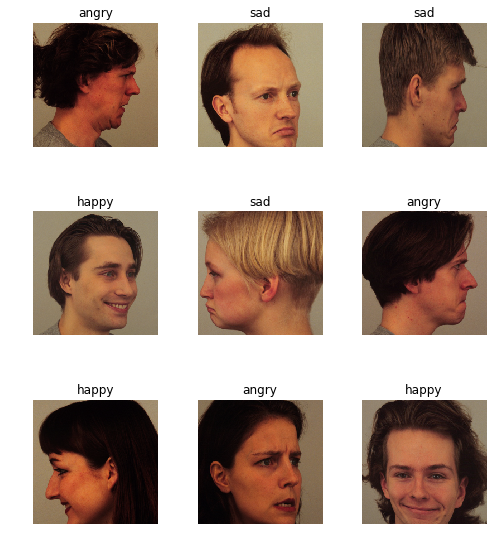

In [16]:
data.show_batch(rows=3, figsize=(7,8))

## Train model on kdef dataset

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [18]:
learn.fit_one_cycle(4)

Total time: 01:08
epoch  train_loss  valid_loss  error_rate
1      1.193058    0.876668    0.404922    (00:18)
2      0.943994    0.714257    0.297539    (00:16)
3      0.796826    0.617984    0.259508    (00:16)
4      0.692911    0.589558    0.248322    (00:16)



In [19]:
learn.save('stage-1')

First stage done and saved. Now let us try to improve it.

In [20]:
learn.unfreeze()
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


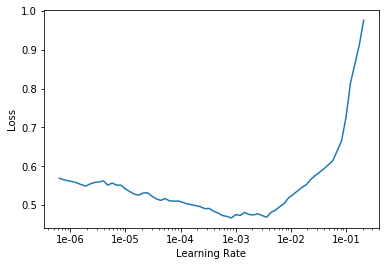

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,8e-4))

Total time: 00:33
epoch  train_loss  valid_loss  error_rate
1      0.500580    0.397031    0.145414    (00:16)
2      0.350332    0.248827    0.091723    (00:16)



In [24]:
learn.save('stage-2')

## Interpret results from KDEF dataset

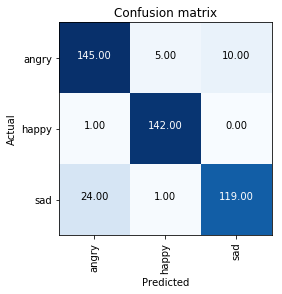

In [25]:
learn.load('stage-2')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [26]:
interp.most_confused(min_val=2)

[('sad', 'angry', 24), ('angry', 'sad', 10), ('angry', 'happy', 5)]

So after stage 2, the model has a 9% error rate and is mostly confused between angry and sad.

Going to apply this model on the dataset downloaded from Google image search of the phrases "human face angry/happy/sad" and see how it performs.

# Dataset from Google Search - Work In Progress

Ok, so I'm going to attempt to create a second dataset from Google images and run the trained model on those. Similar to how Lesson 2 does it for one image (Production example) but I want to do it over an entire dataset. So that means creating an ImageDataBunch from classes?

In [34]:
folderfilearray = [('happy', 'urls_happy.txt'),('sad', 'urls_sad.txt'),('angry', 'urls_angry.txt')]
path = Path('data/emotion')
#for i in range(len(folderfilearray)):
#    folder = folderfilearray[i][0]
#    dest = path/folder
#    dest.mkdir(parents=True, exist_ok=True)

Great. That should create all the folders, one per class, so we can store our images in them. Time to upload the url files to the path directory and then run script to read urls file and download images to specific folders.

But first, name your classes (using label names to keep it simple)

In [35]:
classes = []
for i in range(len(folderfilearray)):
    classes.append(folderfilearray[i][0])
print(classes)

['happy', 'sad', 'angry']


Now, run through all classes to download images from urls file to dest folder. Let's get 70 pics of each kind for now. Then clean up to remove images we cant open in each folder. Then manually prune. Hopefully we have at least 50 good pictures by the end.

In [36]:
for i in range(len(folderfilearray)):
    file = folderfilearray[i][1]
    dest = path/classes[i]
    print("\nReading urls from", file)
    print("Destination folder set to", dest)
    #print("\nDownloading images now..")
    #download_images(path/file, dest, max_pics=70)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)


Reading urls from urls_happy.txt
Destination folder set to data/emotion/happy

Verifying images now..



Reading urls from urls_sad.txt
Destination folder set to data/emotion/sad

Verifying images now..



Reading urls from urls_angry.txt
Destination folder set to data/emotion/angry

Verifying images now..


Ok, time to create the ImageDataBunch to prep for training, and view the data. Also manually prune the data to improve its quality.

In [7]:
np.random.seed(42) #ensures validation set remains same in every run
dataGoogle = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [8]:
#dataGoogle.classes, dataGoogle.c, len(dataGoogle.train_ds), len(dataGoogle.valid_ds)

(['angry', 'happy', 'sad'], 3, 103, 35)

### Question
I have 210 (70x3) images in my dataset. So 42 in validation set makes sense (pct is 20%). But why do I have only 132 in the training set? Is that because the others could not be read/downloaded? Does that mean that ImageDataBunch will always ensure the validation set is selected to pct values and all image errors will only impact the training set?

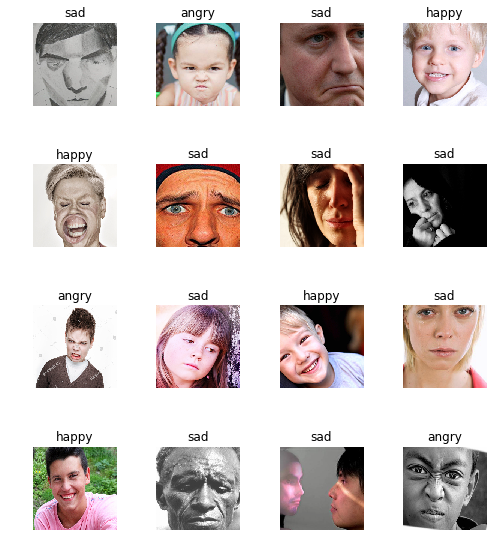

In [9]:
data.show_batch(rows=4, figsize=(7,8))

## Train the model

Ok, now we have our imagedatabunch ready with all the data. Go ahead and create a convolutional nueral network using the resnet34 architecture and run the data through it to train it on emotions.

In [10]:
learn = create_cnn (data, models.resnet34, metrics=error_rate)

Using this learn object that represents your CNN, train it over 4 cycles/epochs.

In [11]:
learn.fit_one_cycle(6)

Total time: 00:45
epoch  train_loss  valid_loss  error_rate
1      1.622043    1.094717    0.600000    (00:08)
2      1.426670    1.099027    0.428571    (00:07)
3      1.178036    1.102868    0.428571    (00:08)
4      0.994850    1.121190    0.542857    (00:06)
5      0.874496    1.100153    0.485714    (00:07)
6      0.766666    1.070379    0.485714    (00:05)



Error rate is really high. Time to save, unfreeze and find a better learning rate and run again with that rate.

In [12]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


Now plot the learning rates to visually spot the right range for LR

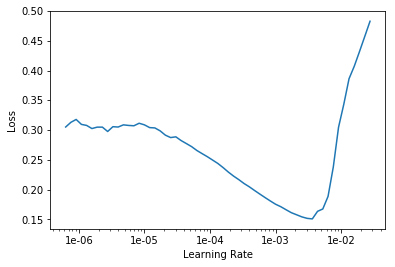

In [13]:
learn.recorder.plot()

Looks like the loss rapidly reduced when learning rate was between neg5 and neg3. Lets try that.

In [15]:
learn.fit_one_cycle(3, max_lr=slice(2e-4,1e-3))

Total time: 00:21
epoch  train_loss  valid_loss  error_rate
1      0.234697    1.143734    0.400000    (00:07)
2      0.206740    1.045939    0.400000    (00:05)
3      0.192205    0.932937    0.400000    (00:08)



Still not much improvement. Time to look at top losses and clean up the data.

In [16]:
learn.save('stage-2')

## Interpretation

In [74]:
learn.load('stage-2')

In [75]:
interp = ClassificationInterpretation.from_learner(learn)

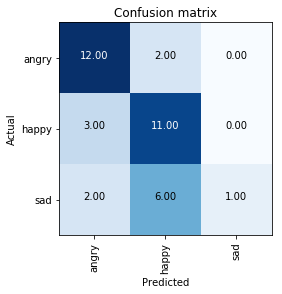

In [76]:
interp.plot_confusion_matrix()

## Cleanup the data

After training the model once we can identify the top losses and look the images that caused them. Then manually prune the data to improve the training accuracy.

In [77]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [78]:
fd = FileDeleter(file_paths=top_loss_paths)

'No images to show :)'